In [37]:
import pandas as pd
import numpy as np
import tarfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import string
import scipy as sp
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import import_ipynb
import Path
import warnings
warnings.filterwarnings('ignore')

In [39]:
os.chdir(Path.path)
file = tarfile.open('aclImdb_v1.tar.gz')
file.extractall()
file.close()

In [3]:
os.listdir()

['.ipynb_checkpoints',
 'aclImdb',
 'aclImdb_v1.tar.gz',
 'MovieReview.ipynb',
 'test',
 'train']

In [40]:
def extract_data(cat, rat):
    os.chdir(Path.path)
    id_list = []
    rating_list = []
    content_list = []
    os.chdir(f"{cat}\\{rat}\\")
    r = os.getcwd()
    for file in os.listdir(r):
        id_list.append(file.split('_')[0])
        rating_list.append(file.split('_')[1][0])
        with open(file, 'r', encoding='utf-8') as f:
            content_list.append(f.read())
    return id_list, rating_list, content_list

In [5]:
train_neg_id, train_neg_rat, train_neg_cont = extract_data('train', 'neg')
train_pos_id, train_pos_rat, train_pos_cont = extract_data('train', 'pos')
test_neg_id, test_neg_rat, test_neg_cont = extract_data('test', 'neg')
test_pos_id, test_pos_rat, test_pos_cont = extract_data('test', 'pos')

In [6]:
train_neg = pd.DataFrame({'rating':train_neg_rat, 'review':train_neg_cont})
train_pos = pd.DataFrame({'rating':train_pos_rat, 'review':train_pos_cont})
train = pd.concat([train_neg, train_pos])
train.head()

,rating,review
0,3,Story of a man who has unnatural feelings for ...
1,4,Airport '77 starts as a brand new luxury 747 p...
2,4,This film lacked something I couldn't put my f...
3,1,"Sorry everyone,,, I know this is supposed to b..."
4,1,When I was little my parents took me along to ...


In [7]:
test_neg = pd.DataFrame({'rating':test_neg_rat, 'review':test_neg_cont})
test_pos = pd.DataFrame({'rating':test_pos_rat, 'review':test_pos_cont})
test = pd.concat([test_neg, test_pos])
test.head()

,rating,review
0,2,Once again Mr. Costner has dragged out a movie...
1,4,This is an example of why the majority of acti...
2,1,"First of all I hate those moronic rappers, who..."
3,3,Not even the Beatles could write songs everyon...
4,3,Brass pictures (movies is not a fitting word f...


In [8]:
train['rating'] = train['rating'].astype('int64')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 0 to 12499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  25000 non-null  int64 
 1   review  25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 585.9+ KB


In [10]:
test['rating'] = test['rating'].astype('int64')

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 0 to 12499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  25000 non-null  int64 
 1   review  25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 585.9+ KB


In [12]:
train.describe()

,rating
count,25000.000000
mean,3.774200
std,3.006402
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,9.000000


In [13]:
test.describe()

,rating
count,25000.000000
mean,3.713320
std,2.999036
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,9.000000


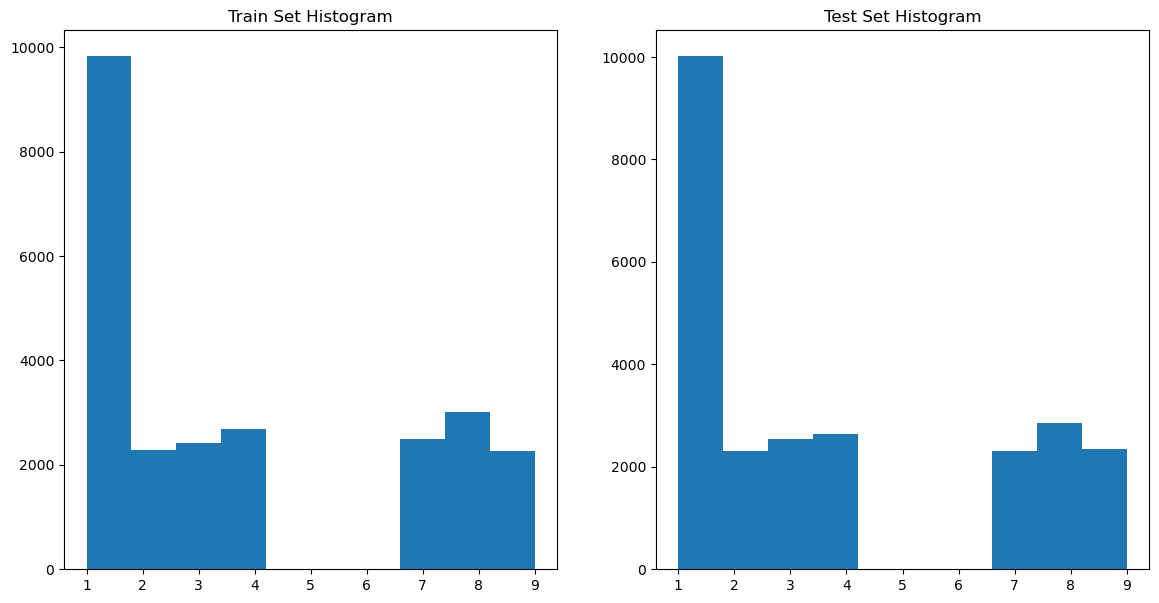

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14,7))
axes[0].hist(train['rating'])
axes[0].set_title('Train Set Histogram')
axes[1].hist(test['rating'])
axes[1].set_title('Test Set Histogram')
plt.show()

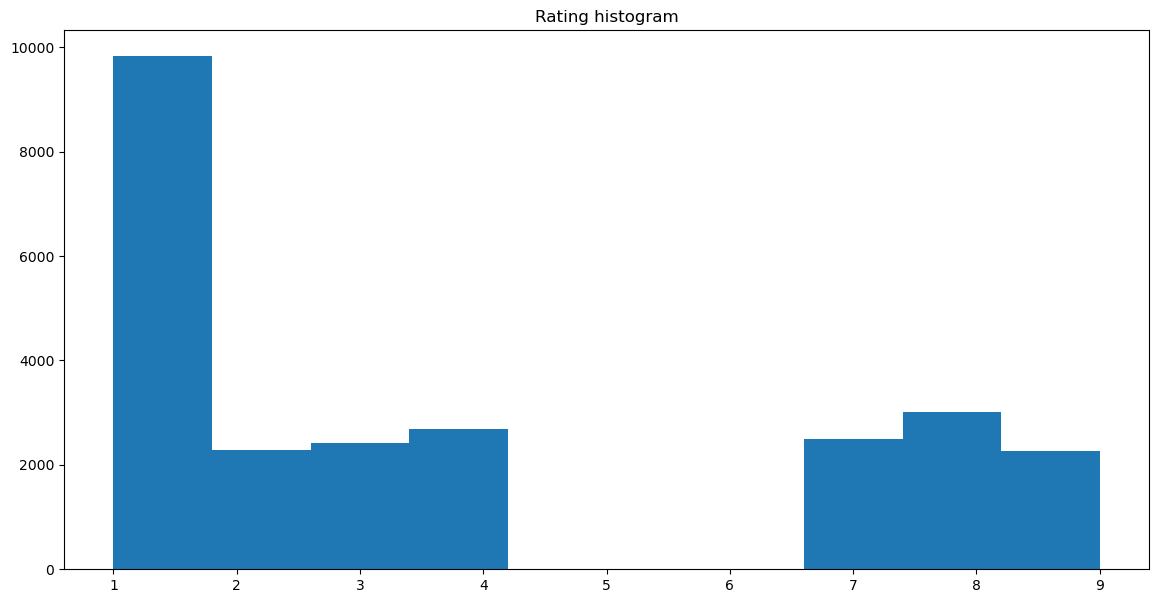

In [16]:
fig = plt.figure(figsize=(14,7))
plt.hist(train['rating'])
plt.title('Rating histogram')
plt.show()

In [17]:
def classify(movie_set):
    movie_set['label'] = movie_set['rating'].apply(lambda x: 'neg' if x <= 4 else 'pos')

In [18]:
classify(train)
classify(test)

In [19]:
train['length'] = train['review'].str.split(' ').str.len()

In [20]:
train.head()

,rating,review,label,length
0,3,Story of a man who has unnatural feelings for ...,neg,112
1,4,Airport '77 starts as a brand new luxury 747 p...,neg,801
2,4,This film lacked something I couldn't put my f...,neg,141
3,1,"Sorry everyone,,, I know this is supposed to b...",neg,154
4,1,When I was little my parents took me along to ...,neg,395


In [21]:
test.head()

,rating,review,label
0,2,Once again Mr. Costner has dragged out a movie...,neg
1,4,This is an example of why the majority of acti...,neg
2,1,"First of all I hate those moronic rappers, who...",neg
3,3,Not even the Beatles could write songs everyon...,neg
4,3,Brass pictures (movies is not a fitting word f...,neg


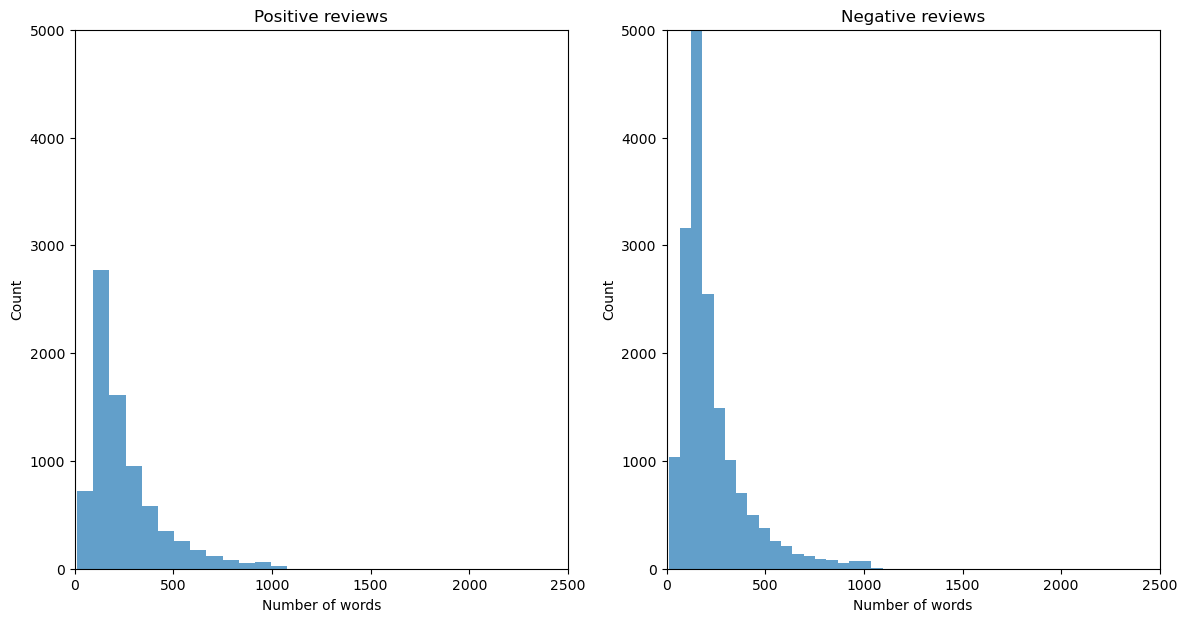

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14,7))
pos = train['length'][train['label'] == 'pos']
neg = train['length'][train['label'] == 'neg']
axes[0].hist(pos, bins=30, alpha=0.7)
axes[0].set_xlim([0, 2500])
axes[0].set_ylim([0,5000])
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Number of words')
axes[0].set_title('Positive reviews')
axes[1].hist(neg, bins=30, alpha=0.7)
axes[1].set_xlim([0, 2500])
axes[1].set_ylim([0,5000])
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Number of words')
axes[1].set_title('Negative reviews')
plt.show()

In [23]:
train.groupby('label').describe()

rating                                                length  \
         count      mean       std  min  25%  50%  75%  max    count   
label                                                                  
neg    17232.0  1.882776  1.150283  1.0  1.0  1.0  3.0  4.0  17232.0   
pos     7768.0  7.970005  0.782190  7.0  7.0  8.0  9.0  9.0   7768.0   

                                                                  
             mean         std   min    25%    50%    75%     max  
label                                                             
neg    225.124884  167.966103  10.0  125.0  168.0  268.0  1723.0  
pos    252.969361  184.403170  12.0  131.0  191.0  316.0  2470.0

In [24]:
train.head()

,rating,review,label,length
0,3,Story of a man who has unnatural feelings for ...,neg,112
1,4,Airport '77 starts as a brand new luxury 747 p...,neg,801
2,4,This film lacked something I couldn't put my f...,neg,141
3,1,"Sorry everyone,,, I know this is supposed to b...",neg,154
4,1,When I was little my parents took me along to ...,neg,395


In [25]:
train.drop('rating', inplace=True, axis=1)
test.drop('rating', inplace=True, axis=1)

In [26]:
train.head()

,review,label,length
0,Story of a man who has unnatural feelings for ...,neg,112
1,Airport '77 starts as a brand new luxury 747 p...,neg,801
2,This film lacked something I couldn't put my f...,neg,141
3,"Sorry everyone,,, I know this is supposed to b...",neg,154
4,When I was little my parents took me along to ...,neg,395


In [41]:
# text processing
''' 
remove punc
remove stopwords
return list
'''
def text_processing(review):
    nopunc = [char for char in review if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
# sprobowac z word.lower()

In [47]:
sample_size = 500
train_sample = train.sample(n=sample_size, random_state=24)
test_sample = test.sample(n=sample_size, random_state=24)

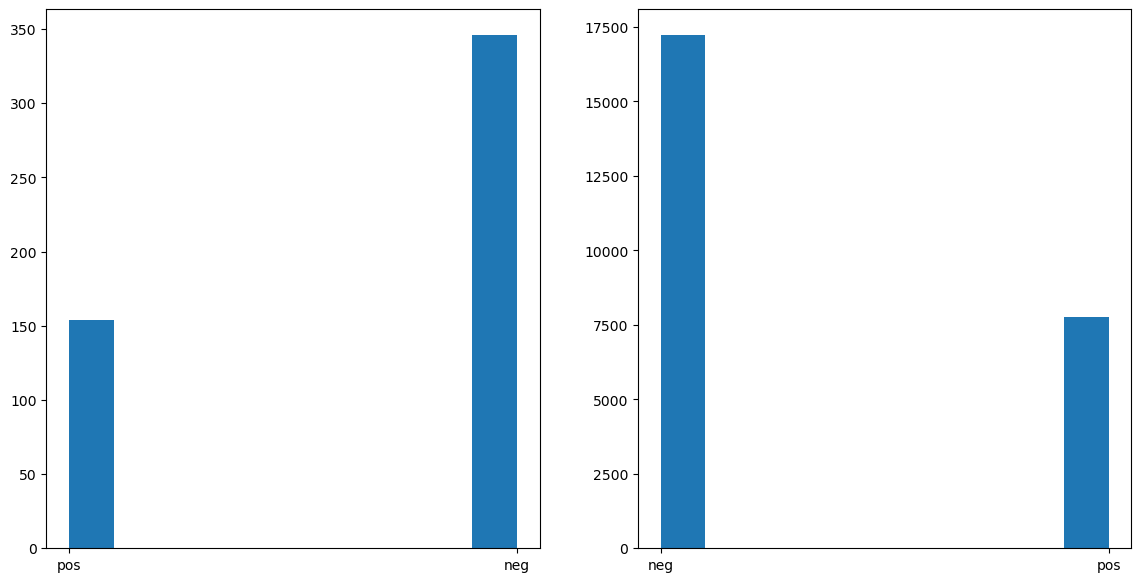

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14,7))
axes[0].hist(train_sample['label'])
axes[1].hist(train['label'])
plt.show()

In [40]:
train_sample['review'].apply(text_processing)

8925    [like, Ronald, Colman, dashing, debonair, fell...
9867    [Im, going, comb, TLPSs, obvious, peterbogdano...
2918    [areas, overlap, fine, movie, light, years, ah...
6193    [dont, need, read, reviewbr, br, earlier, revi...
7064    [cant, help, laugh, people, praise, show, hear...
                              ...                        
532     [Someone, explain, every, film, features, poor...
5586    [Even, though, animated, film, really, bored, ...
3301    [meteor, hits, Crater, Lake, hence, title, awa...
7783    [great, film, Meryl, Streep, Jack, Nicholson, ...
7813    [Ah, sexandgore, movie, bad, dont, make, anymo...
Name: review, Length: 500, dtype: object

In [42]:
def szukam_nazwy(dataset):
    bow = CountVectorizer(analyzer=text_processing).fit_transform(dataset)
    print(f'BoW shape: {bow.shape}')
    tfidf = TfidfTransformer().fit_transform(bow)
    return tfidf

In [53]:
CV = CountVectorizer(analyzer=text_processing)
TfiDf = TfidfTransformer()

In [54]:
bow_train = CV.fit_transform(train_sample['review'])
tfidf_train = TfiDf.fit_transform(bow_train)

In [55]:
model = MultinomialNB()
model.fit(szukam_nazwy(train_sample['review']), train_sample['label'])

BoW shape: (500, 14525)


MultinomialNB()

In [56]:
bow_test = CV.transform(test_sample['review'])
tfidf_test = TfiDf.transform(bow_test)

In [57]:
predictions = model.predict(tfidf_test)
print(classification_report(predictions, test_sample['label']))
print(confusion_matrix(predictions, test_sample['label']))

              precision    recall  f1-score   support

         neg       1.00      0.70      0.82       500
         pos       0.00      0.00      0.00         0

    accuracy                           0.70       500
   macro avg       0.50      0.35      0.41       500
weighted avg       1.00      0.70      0.82       500

[[350 150]
 [  0   0]]


In [ ]:
print(classification_report(predictions, test['label']))
print(confusion_matrix(predictions, test['label']))
print(f1_score(predictions, test['label'], average='weighted'))